## Evaluación y mejoras  de los modelos

Para evaluar los modelos supervisados, hasta ahora hemos dividido nuestro conjunto de datos en un conjunto de entrenamiento y un conjunto de prueba utilizando la función `train_test_split`, construimos un modelo en el conjunto de entrenamiento llamando al método `fit` y lo evaluamos en el conjunto de prueba utilizando el método `score`, que para la clasificación calcula la fracción de muestras correctamente clasificadas. La evaluación y selección de modelos en el aprendizaje no supervisado es a menudo un proceso muy cualitativo.

A quí hay un ejemplo de ese proceso, para el caso de modelos supervisados:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# creamos datos artificiales
X, y = make_blobs(random_state=0)

# dividimos datos y etiquetas en un entrenamiento y un conjunto de prueba
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, random_state=0)

# creamos una instancia de un modelo y ajustarlo al conjunto de entrenamiento
logreg = LogisticRegression().fit(X_entrenamiento, y_entrenamiento)

# evaluamos el modelo en el conjunto de prueba
print("Puntuacion del conjunto de pruebas: {:.2f}".format(logreg.score(X_prueba, y_prueba)))

Puntuacion del conjunto de pruebas: 0.88


Recuerda, que la razón por la que dividimos nuestros datos en conjuntos de entrenamiento y prueba es que estamos interesados en medir qué tan bien nuestro modelo se generaliza a datos nuevos, nunca antes vistos.
No estamos interesados en qué tan bien nuestro modelo se ajusta al conjunto de entrenamiento, sino en qué tan bien puede hacer predicciones para los datos que no se observaron durante el entrenamiento.

Vamos a ampliar dos aspectos de esta evaluación. Primero introduciremos la validación cruzada, una forma más sólida de evaluar el rendimiento de generalización  y discutiremos los métodos para evaluar el rendimiento de clasificación y regresión que van más allá de las medidas predeterminadas de precisión y $R^2$ proporcionadas por el método `score`.

Existen otros meétodos como la búsqueda grid, un método efectivo para ajustar los parámetros en los modelos para obtener el mejor rendimiento de la generalización.


### Validación cruzada

La validación cruzada es un método estadístico para evaluar el rendimiento de generalización que es más estable y exhaustivo que el uso de una división en un entrenamiento y un conjunto de prueba. En la validación cruzada, los datos se dividen en varias ocasiones y se entrena a varios modelos.

La versión más comúnmente utilizada de la validación cruzada es `k-fold cross-validation` (validación cruzada de k grupos), donde k es un número especificado por el usuario, generalmente 5 o 10. Al realizar una validación cruzada de cinco grupos, los datos se dividen primero en cinco partes de ( aproximadamente) de igual tamaño, llamados `folds` (grupos).

A continuación, se entrena una secuencia de modelos. El primer modelo se entrena utilizando el primer grupo  como conjunto de prueba, y los grupos  restantes (2-5) se usan como conjunto de entrenamiento. El modelo se construye usando los datos en los grupos 2-5, y luego la precisión se evalúa en el grupo 1. Luego se construye otro modelo, esta vez usando el grupo 2 como el conjunto de prueba y los datos en los grupos 1, 3, 4 y 5 como el conjunto de entrenamiento.

Este proceso se repite usando los grupos 3, 4 y 5 como conjuntos de prueba. Para cada una de estas cinco divisiones de los datos en los conjuntos de entrenamiento y prueba, calculamos la precisión. Al final, hemos recopilado cinco valores de precisión. El proceso se ilustra en la figura:

In [2]:
def dibuja_validacion_cruzada():
    plt.figure(figsize=(12, 2))
    plt.title("Validacion cruzada")
    axes = plt.gca()
    axes.set_frame_on(False)

    n_grupos = 5
    n_muestras = 25

    n_muestras_por_grupos = n_muestras/float(n_grupos)

    for i in range(n_grupos):
        colores = ["w"] * n_grupos
        colores[i] = "grey"
        bars = plt.barh(y=range(n_grupos), width=[n_muestras_por_grupos - 0.1] * n_grupos,
            left=i * n_muestras_por_grupos, height=.6, color=colores, hatch="//",
            edgecolor='k', align='edge')
    axes.invert_yaxis()
    axes.set_xlim(0, n_muestras + 1)
    plt.ylabel("Interaciones CV")
    plt.xlabel("Puntos de datos")
    plt.xticks(np.arange(n_muestras_por_grupos / 2., n_muestras,
                         n_muestras_por_grupos),
               ["Grupos %d" % x for x in range(1, n_grupos + 1)])
    plt.yticks(np.arange(n_grupos) + .3,
               ["Division %d" % x for x in range(1, n_grupos + 1)])
    plt.legend([bars[0], bars[4]], ['Datos de entrenamiento', 'Datos de prueba'],
               loc=(1.05, 0.4), frameon=False)

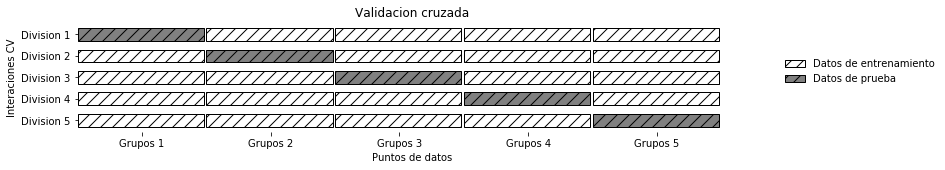

In [3]:
dibuja_validacion_cruzada()

Por lo general, el primer quinto de los datos es el primer grupo, el segundo quinto de los datos es el segundo grupo, y así sucesivamente.

### Validación cruzada en scikit-learn

La validación cruzada se implementa en scikit-learn utilizando la función `cross_val_score` del módulo `model_selection`. Los parámetros de la función `cross_val_score` son el  modelo que queremos evaluar, los datos de entrenamiento y las etiquetas de evidencia empírica. Evaluemos LogisticRegression con el conjunto de datos `iris`:

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
iris = load_iris()
logreg = LogisticRegression()
puntuacion= cross_val_score(logreg, iris.data, iris.target)
print("Puntuacion de validacion cruzada: {}".format(puntuacion))

Puntuacion de validacion cruzada: [0.96078431 0.92156863 0.95833333]


De forma predeterminada, `cross_val_score` realiza una validación cruzada de tres grupos, y devuelve tres valores de precisión. Podemos cambiar la cantidad de grupos utilizados cambiando el parámetro `cv`:

In [5]:
puntuacion= cross_val_score(logreg, iris.data, iris.target, cv=5)
print("Puntuacion de validacion cruzada: {}".format(puntuacion))

Puntuacion de validacion cruzada: [1.         0.96666667 0.93333333 0.9        1.        ]


Una forma común de resumir la precisión de la  validación cruzada es calcular la media:

In [6]:
print("Promedio de las puntuaciones de validacion cruzada: {}".format(puntuacion.mean()))

Promedio de las puntuaciones de validacion cruzada: 0.9600000000000002


Usando la validación cruzada promedio, podemos concluir que el modelo tiene una precisión alrededor del 96% en promedio. En cuanto a los cinco puntajes producidos por la validación cruzada de cinco grupos, podemos concluir también que hay una varianza relativamente alta en la precisión entre los grupos, que van desde el 100% de precisión hasta el 90% de precisión. Esto podría implicar que el modelo es muy dependiente de los grupos particulares utilizados para el entrenamiento, pero también podría ser una consecuencia del pequeño tamaño del conjunto de datos.

### Beneficios de la validación 

El uso de la validación cruzada en lugar de una única división de un conjunto de entrenamiento y un conjunto de prueba brinda varios beneficios. Primero, recuerde que `train_test_split` realiza una división aleatoria de los datos. Imaginamos que tenemos "suerte" al dividir al azar los datos, y todos los ejemplos que son difíciles de clasificar terminan en el conjunto de entrenamiento. En ese caso, el conjunto de prueba solo contendrá ejemplos "fáciles"  y nuestra precisión en el conjunto de pruebas será irrealmente alta.

Por el contrario, si tenemos "mala suerte", podríamos haber puesto al azar todos los ejemplos difíciles de clasificar en el conjunto de pruebas y consecuentemente obtener un puntaje bajo irrealmente. Sin embargo, al usar la validación cruzada, cada ejemplo estará en el conjunto de entrenamiento exactamente una vez: cada ejemplo está en uno de los grupos, y cada grupo es el conjunto de prueba una vez. Por lo tanto, el modelo necesita generalizar bien a todas las muestras en el conjunto de datos para que todos los puntajes de validación cruzada (y su media) sean altos.

Tener múltiples divisiones de los datos también proporciona cierta información acerca de cuán sensible es nuestro modelo para la selección del conjunto de datos de entrenamiento. Para el conjunto de datos del iris, vimos precisiones entre 90% y 100%. Este es un amplio rango, y nos da una idea de cómo el modelo podría funcionar en el peor de los casos y los mejores escenarios posibles cuando se aplica a nuevos datos.

Otro beneficio de la validación cruzada en comparación con el uso de una sola división de los datos es que utilizamos nuestros datos de manera más efectiva. Cuando se utiliza train_test_split, generalmente usamos el 75% de los datos para el entrenamiento y el 25% de los datos para la evaluación. Al usar una validación cruzada de cinco grupos, en cada iteración podemos usar cuatro quintos de los datos (80%) para ajustar el modelo. Al usar una validación cruzada de 10 grupos, podemos usar nueve décimas partes de los datos (90%) para ajustar el modelo. Más datos generalmente darán como resultado modelos más precisos.


La principal desventaja de la validación cruzada es un mayor costo computacional. Como ahora estamos entrenando k modelos en lugar de un único modelo, la validación cruzada será aproximadamente k veces más lenta que una sola división de los datos.

Es importante tener en cuenta que la validación cruzada no es una forma de construir un modelo que se pueda aplicar a nuevos datos. La validación cruzada no devuelve un modelo. Cuando se llama a `cross_val_score`, se crean varios modelos internamente, pero el propósito de la validación cruzada es evaluar qué tan bien se generalizará un algoritmo determinado cuando se entrene en un conjunto de datos específico.

### Validación cruzada estratificada y otras estrategias

Si dividimos el conjunto de datos en k grupos comenzando con la primera parte de la k-ésima parte de los datos, como se describe en la sección anterior, puede no ser siempre una buena idea. Por ejemplo, echemos un vistazo al conjunto de datos de iris:


In [7]:
from sklearn.datasets import load_iris
iris = load_iris()
print("Etiqueta iris:\n{}".format(iris.target))

Etiqueta iris:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


Como se puede ver, el primer tercio de los datos es de la clase 0, el segundo tercio es de la clase 1 y el último tercio es de la clase 2. Imaginemos realizar una validación cruzada de tres grupos en este conjunto de datos. El primer grupo solo sería de clase 0, por lo que en la primera división de los datos, el conjunto de prueba sería solo de clase 0, y el conjunto de entrenamiento sería solo de clase 1 y 2. Como las clases en el entrenamiento y los conjuntos de prueba serían diferentes para las tres divisiones, la precisión de validación cruzada de tres grupos sería cero en este conjunto de datos. Eso no es muy útil, ya que podemos hacer mucho mejor que el 0% de precisión en el datos de iris.

Como la estrategia simple de k-grupos falla aquí, scikit-learn no la usa para la clasificación, sino que usa la validación cruzada de k-grupos estratificada. En la validación cruzada estratificada, dividimos los datos de forma que las proporciones entre las clases sean las mismas en cada grupo, que en el conjunto de datos completo, como se ilustra en la siguiente figura:

In [8]:
def dibuja_validacion_cruzada_estratificada():
    fig, both_axes = plt.subplots(2, 1, figsize=(12, 5))
    axes = both_axes[0]
    axes.set_title("Validacion cruzada estandar con etiquetas de clase clasificadas")

    axes.set_frame_on(False)

    n_grupos = 3
    n_muestras = 150

    n_muestras_por_grupo = n_muestras / float(n_grupos)

    for i in range(n_grupos):
        colors = ["w"] * n_grupos
        colors[i] = "grey"
        axes.barh(y=range(n_grupos), width=[n_muestras_por_grupo - 1] *
                  n_grupos, left=i * n_muestras_por_grupo, height=.6,
                  color=colors, hatch="//", edgecolor='k', align='edge')

    axes.barh(y=[n_grupos] * n_grupos, width=[n_muestras_por_grupo - 1] *
              n_grupos, left=np.arange(3) * n_muestras_por_grupo, height=.6,
              color="w", edgecolor='k', align='edge')

    axes.invert_yaxis()
    axes.set_xlim(0, n_muestras + 1)
    axes.set_ylabel("Iteraciones CV")
    axes.set_xlabel("Puntos de datos")
    axes.set_xticks(np.arange(n_muestras_por_grupo / 2.,
                              n_muestras, n_muestras_por_grupo))
    axes.set_xticklabels(["Grupo %d" % x for x in range(1, n_grupos + 1)])
    axes.set_yticks(np.arange(n_grupos + 1) + .3)
    axes.set_yticklabels(
        ["Division %d" % x for x in range(1, n_grupos + 1)] + ["Etiquetas de clase"])
    for i in range(3):
        axes.text((i + .5) * n_muestras_por_grupo, 3.5, "Clase %d" %
                  i, horizontalalignment="center")

    ax = both_axes[1]
    ax.set_title("Validacion cruzada estratificada")
    ax.set_frame_on(False)
    ax.invert_yaxis()
    ax.set_xlim(0, n_muestras + 1)
    ax.set_ylabel("IteracionesCV ")
    ax.set_xlabel("Puntos de datos")

    ax.set_yticks(np.arange(n_grupos + 1) + .3)
    ax.set_yticklabels(
        ["Division %d" % x for x in range(1, n_grupos + 1)] + ["Etiquetas de clase"])

    n_subsplit = n_muestras_por_grupo / 3.
    for i in range(n_grupos):
        bar_prueba = ax.barh(
            y=[i] * n_grupos, width=[n_subsplit - 1] * n_grupos,
            left=np.arange(n_grupos) * n_muestras_por_grupo + i * n_subsplit,
            height=.6, color="grey", hatch="//", edgecolor='k', align='edge')

    w = 2 * n_subsplit - 1
    ax.barh(y=[0] * n_grupos, width=[w] * n_grupos, left=np.arange(n_grupos)
            * n_muestras_por_grupo + (0 + 1) * n_subsplit, height=.6, color="w",
            hatch="//", edgecolor='k', align='edge')
    ax.barh(y=[1] * (n_grupos + 1), width=[w / 2., w, w, w / 2.],
            left=np.maximum(0, np.arange(n_grupos + 1) * n_muestras_por_grupo -
                            n_subsplit), height=.6, color="w", hatch="//",
            edgecolor='k', align='edge')
    bar_entrenamiento = ax.barh(y=[2] * n_grupos, width=[w] * n_grupos,
                            left=np.arange(n_grupos) * n_muestras_por_grupo,
                            height=.6, color="w", hatch="//", edgecolor='k',
                            align='edge')

    ax.barh(y=[n_grupos] * n_grupos, width=[n_muestras_por_grupo - 1] *
            n_grupos, left=np.arange(n_grupos) * n_muestras_por_grupo, height=.6,
            color="w", edgecolor='k', align='edge')

    for i in range(3):
        ax.text((i + .5) * n_muestras_por_grupo, 3.5, "Clase %d" %
                i, horizontalalignment="center")
    ax.set_ylim(4, -0.1)
    plt.legend([bar_entrenamiento[0], bar_prueba[0]], [
               'Datos de entrenamiento', 'Datos de prueba'], loc=(1.05, 1), frameon=False)

    fig.tight_layout()

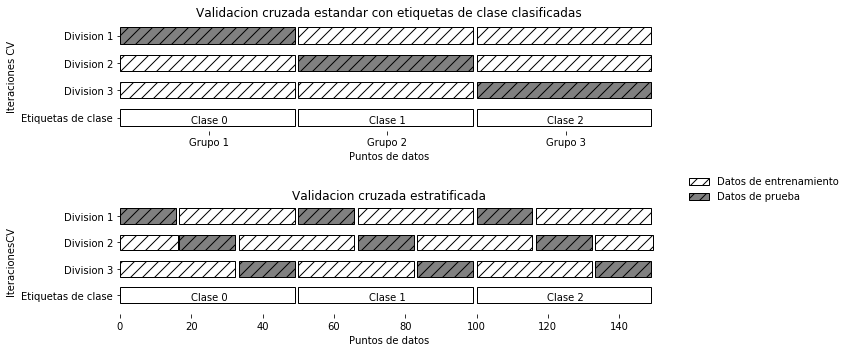

In [9]:
dibuja_validacion_cruzada_estratificada()

Por ejemplo, si el 90% de las muestras pertenecen a la clase A y el 10% de las muestras pertenecen a la clase B, la validación cruzada estratificada garantiza que en cada grupo el 90% de las muestras pertenecen a la clase A y el 10% de las muestras pertenecen a clase B.

Por lo general, es una buena idea utilizar la validación cruzada estratificada en lugar de la validación cruzada usual para evaluar un clasificador, ya que da como resultado estimaciones más confiables del rendimiento de la generalización. En el caso de solo el 10% de las muestras pertenecientes a la clase B, utilizando la validación cruzada estándar, podría suceder que un grupo solo contenga muestras de clase A. Usar este grupo como un conjunto de prueba no sería muy informativo sobre el rendimiento general del clasificador.

Para la regresión, scikit-learn utiliza la validación cruzada de estándar por defecto. También sería posible tratar de hacer que cada grupo  sea representativo de los diferentes valores que tiene el objetivo de regresión, pero esta no es una estrategia comúnmente utilizada y sería sorprendente para la mayoría de los usuarios.

### Más control sobre la validación cruzada

Vimos anteriormente que podemos ajustar la cantidad de grupos que se usan en `cross_val_score` usando el parámetro `cv`. Sin embargo, scikit-learn permite un control mucho más fino sobre lo que sucede durante la división de los datos al proporcionar un separador de validación cruzada como el parámetro `cv`. Para la mayoría de los casos de uso, los valores predeterminados de la validación cruzada para k grupos para regresión y validación cruzada estratificada para clasificación funcionan bien, pero hay algunos casos en los que es posible que desee utilizar una estrategia diferente.

Digamos, por ejemplo, que queremos usar la validación cruzada  estándar en un conjunto de datos de clasificación para reproducir los resultados de otra persona. Para hacer esto, primero tenemos que importar el separador `KFold` del módulo `model_selection` e instanciarlo con el número de grupos que queremos usar:


In [10]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

Entonces, podemos pasar el objeto separador `kfold` como el parámetro `cv` a `cross_val_score`:

In [11]:
print("Puntuacion de validacion cruzada:\n{}".format( cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Puntuacion de validacion cruzada:
[1.         0.93333333 0.43333333 0.96666667 0.43333333]


De esta forma, podemos verificar que realmente es una mala idea usar una validación cruzada usando tres grupos (no estratificada) en el conjunto de datos del iris:

In [12]:
kfold = KFold(n_splits=3)
print("Puntuacion de validacion cruzada:\n{}".format(cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Puntuacion de validacion cruzada:
[0. 0. 0.]


Cada grupo corresponde a una de las clases del dataset del iris, por lo que no se puede aprender nada. Otra forma de resolver este problema es mezclar los datos en lugar de estratificar los grupos, para eliminar el orden de las muestras por etiqueta. Podemos hacer eso configurando el parámetro `shuffle` de `KFold` a `True`.

Si mezclamos los datos, también necesitamos austar el `random_state` para obtener una mezcla reproducible. De lo contrario, cada ejecución de `cross_val_score` arrojaría un resultado diferente, ya que cada vez se usaría un separador diferente (esto podría no ser un problema, pero puede ser sorprendente). Mezclar los datos antes dividirlo produce un resultado mucho mejor:

In [13]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print("Puntuacion de validacion cruzada:\n{}".format(cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Puntuacion de validacion cruzada:
[0.9  0.96 0.96]


### Validación cruzada dejando uno fuera

Otro método de validación cruzada utilizado con frecuencia es `leave-one-out`. Se puede pensar en la `validación cruzada dejando uno fuera`, como una validación cruzada donde cada grupo es una sola muestra. Para cada división, se elige un único punto de datos para ser el conjunto de prueba. Esto puede consumir mucho tiempo, especialmente para grandes conjuntos de datos, pero a veces proporciona mejores estimaciones en pequeños conjuntos de datos:

In [14]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
puntuacion= cross_val_score(logreg, iris.data, iris.target, cv=loo)
print("Numero interaciones cv : ", len(puntuacion))
print("Precision media: {:.2f}".format(puntuacion.mean()))

Numero interaciones cv :  150
Precision media: 0.95


### La validación cruzada dividida aleatoriamente

Otra estrategia muy flexible para la validación cruzada es la validación cruzada alaeatoria. En la validación cruzada aleatoria, cada muestra dividida `train_size`  puntos son para el conjunto de entrenamiento y `test_size` puntos (disjuntos) para el conjunto de prueba. Esta división se repite `n_iter` veces. La siguiente figura ilustra la ejecución de cuatro iteraciones de división de un conjunto de datos que consta de 10 puntos, con un conjunto de entrenamiento de 5 puntos y conjuntos de prueba de 2 puntos cada uno (puede usar enteros para `train_size` y `test_size` para usar tamaños absolutos para estos conjuntos o puntos flotantes para usar fracciones de todo el conjunto de datos):

In [15]:
def dibuja_validacion_cruzada_aleatoria():
    from sklearn.model_selection import ShuffleSplit
    plt.figure(figsize=(10, 2))
    plt.title("Validacion cruzada aleatoria con 10 points"
              ", num_entrenamiento=5, num_prueba= 2, n_division=4")

    axes = plt.gca()
    axes.set_frame_on(False)

    n_grupos = 10
    n_muestras = 10
    n_iter = 4
    n_muestras_por_grupo = 1

    ss = ShuffleSplit(n_splits=4, train_size=5, test_size=2, random_state=43)
    mascara_bool = np.zeros((n_iter, n_muestras))
    for i, (entrenamiento, prueba) in enumerate(ss.split(range(10))):
        mascara_bool[i, entrenamiento] = 1
        mascara_bool[i, prueba] = 2

    for i in range(n_grupos):
        colores = ["grey" if x == 2 else "white" for x in mascara_bool[:, i]]

        cajas = axes.barh(y=range(n_iter), width=[1 - 0.1] * n_iter,
                          left=i * n_muestras_por_grupo, height=.6, color=colores,
                          hatch="//", edgecolor='k', align='edge')
        for j in np.where(mascara_bool[:, i] == 0)[0]:
            cajas[j].set_hatch("")

    axes.invert_yaxis()
    axes.set_xlim(0, n_muestras + 1)
    axes.set_ylabel("Interaciones CV")
    axes.set_xlabel("Puntos de datos")
    axes.set_xticks(np.arange(n_muestras) + .5)
    axes.set_xticklabels(np.arange(1, n_muestras + 1))
    axes.set_yticks(np.arange(n_iter) + .3)
    axes.set_yticklabels(["Division %d" % x for x in range(1, n_iter + 1)])
    plt.legend([cajas[1], cajas[0], cajas[2]], [
               "Conjunto de entrenamiento", "Conjunto de prueba", "No seleccionados"], loc=(1, .3))
    plt.tight_layout()


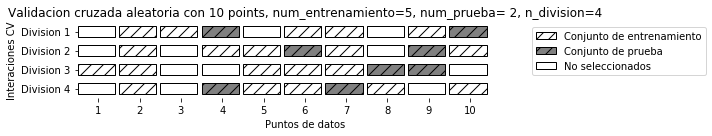

In [16]:
dibuja_validacion_cruzada_aleatoria()

El siguiente código divide el conjunto de datos en 50% de conjunto de entrenamiento y 50% de conjunto de prueba para 10 iteraciones:

In [19]:
from sklearn.model_selection import ShuffleSplit
division_aleatoria = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
puntuacion = cross_val_score(logreg, iris.data, iris.target, cv=division_aleatoria)
print("Puntuacion de validacion cruzada:\n{}".format(puntuacion))

Puntuacion de validacion cruzada:
[0.97333333 0.92       0.93333333 0.92       0.94666667 0.88
 0.96       0.85333333 0.96       0.96      ]


La validación cruzada aleatoria permite controlar el número de iteraciones independientemente de los tamaños de entrenamiento y prueba, lo que a veces puede ser útil. También permite usar solo una parte de los datos en cada iteración, al proporcionar ajustes de `train_size` y `test_size`  que no suman uno. Submuestrear los datos de esta manera puede ser útil para experimentar con grandes conjuntos de datos.

También hay una variante estratificada de `ShuffleSplit`,  llamada `StratifiedShuffleSplit`, que puede proporcionar resultados más confiables para tareas de clasificación.

### Validación cruzada con grupos

Otro escenario muy común para la validación cruzada es cuando hay grupos en los datos que están altamente relacionados. Digamos que quiere construir un sistema para reconocer emociones a partir de imágenes de rostros, y se recopila un conjunto de imágenes de 100 personas donde cada persona es capturada varias veces, mostrando diversas emociones.

El objetivo es construir un clasificador que pueda identificar correctamente las emociones de las personas que no están en el conjunto de datos. Se puede usar la validación cruzada estratificada predeterminada para medir el rendimiento de un clasificador para esta tarea. Sin embargo, es probable que las imágenes de la misma persona estén tanto en el entrenamiento como en el conjunto de prueba. 
Sería más fácil para un clasificador detectar emociones en una cara que es parte del conjunto de entrenamiento, en comparación con una cara completamente nueva. Para evaluar con precisión la generalización a caras nuevas, debemos asegurarnos de que los conjuntos de entrenamiento y prueba contengan imágenes de diferentes personas.

Para lograr esto, podemos usar `GroupKFold`, que toma una matriz de `groups` como argumento que podemos utilizar para indicar qué persona está en la imagen. Esta matriz  indica los grupos en los datos que no se deben dividir cuando se crean los conjuntos de entrenamiento y prueba, y no se debe confundir con la etiqueta de la clase.


#### Ejemplo

Utilizamos un conjunto de datos artificiales con una agrupación dada por la matriz `groups`. El conjunto de datos consta de 12 puntos de datos, y para cada uno de los puntos de datos, `groups` especifican a qué grupo  pertenece el punto. Los grupos especifican que hay cuatro grupos, y las primeras tres muestras pertenecen al primer grupo, las siguientes cuatro muestras pertenecen al segundo grupo, y así sucesivamente:

In [20]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import GroupKFold
# creamos datos artificiales
X, y = make_blobs(n_samples=12, random_state=0)
# asumimos que las primeras tres muestras pertenecen al mismo grupo,
# los cuatras siguientes muestras al segundo, etc.

grupos = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]
puntuacion = cross_val_score(logreg, X, y, grupos, cv=GroupKFold(n_splits=3))
print("Puntuacion de validacion cruzada:\n{}".format(puntuacion))

Puntuacion de validacion cruzada:
[0.75       0.8        0.66666667]


Las muestras no necesitan ordenarse por grupo. Las divisiones que se calculan en base a estas etiquetas se visualizan en la siguiente figura:

In [24]:
def dibuja_grupo_kfold():
    from sklearn.model_selection import GroupKFold
    grupos = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]

    plt.figure(figsize=(10, 2))
    plt.title("GroupKFold")

    axes = plt.gca()
    axes.set_frame_on(False)

    n_grupos = 12
    n_muestras = 12
    n_iter = 3
    n_muestras_por_grupo = 1

    cv = GroupKFold(n_splits=3)
    mascara_bool = np.zeros((n_iter, n_muestras))
    for i, (entrenamiento, prueba) in enumerate(cv.split(range(12), groups=grupos)):
        mascara_bool[i, entrenamiento] = 1
        mascara_bool[i, prueba] = 2

    for i in range(n_grupos):
        colores = ["grey" if x == 2 else "white" for x in mascara_bool[:, i]]
        cajas = axes.barh(y=range(n_iter), width=[1 - 0.1] * n_iter,
                          left=i * n_muestras_por_grupo, height=.6, color=colores,
                          hatch="//", edgecolor="k", align='edge')
        for j in np.where(mascara_bool[:, i] == 0)[0]:
            cajas[j].set_hatch("")

    axes.barh(y=[n_iter] * n_grupos, width=[1 - 0.1] * n_grupos,
              left=np.arange(n_grupos) * n_muestras_por_grupo, height=.6,
              color="w", edgecolor='k', align="edge")

    for i in range(12):
        axes.text((i + .5) * n_muestras_por_grupo, 3.5, "%d" %
                  grupos[i], horizontalalignment="center")

    axes.invert_yaxis()
    axes.set_xlim(0, n_muestras + 1)
    axes.set_ylabel("Iteraciones CV ")
    axes.set_xlabel("Puntos de datos")
    axes.set_xticks(np.arange(n_muestras) + .5)
    axes.set_xticklabels(np.arange(1, n_muestras + 1))
    axes.set_yticks(np.arange(n_iter + 1) + .3)
    axes.set_yticklabels(
        ["Division %d" % x for x in range(1, n_iter + 1)] + ["Grupos"])
    plt.legend([cajas[0], cajas[1]], ["Conjunto de entrenamiento", "Conjunto de prueba"], loc=(1, .3))
    plt.tight_layout()

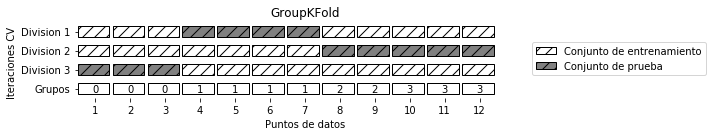

In [25]:
dibuja_grupo_kfold()

Como se puede ver, para cada división, cada grupo está completamente en el conjunto de entrenamiento o completamente en el conjunto de prueba.

### Búsqueda grid

Ahora que sabemos cómo evaluar qué tan bien se generaliza un modelo, podemos dar el siguiente paso y mejorar el rendimiento de generalización del modelo ajustando sus parámetros. Encontrar los valores de los parámetros importantes de un modelo (los que proporcionan el mejor rendimiento de generalización) es una tarea difícil, pero necesaria para casi todos los modelos y conjuntos de datos. Debido a que es una tarea tan común, hay métodos estándar en scikit-learn para ayudarte con eso. El método más comúnmente utilizado es la búsqueda grid, que básicamente significa probar todas las combinaciones posibles de los parámetros de interés.

Considere el caso de un kernel SVM con un núcleo RBF (función de base radial), como se implementó con la clase SVC. Para este cado hay dos parámetros importantes: el ancho de banda del kernel, `gamma` y el parámetro de regularización, `C`. Digamos que queremos probar los valores `0.001`, `0.01`, `0.1`, `1`, `10` y `100` para el parámetro C, y lo mismo para gamma. Debido a que tenemos seis configuraciones diferentes para C y gamma que queremos probar, tenemos 36 combinaciones de parámetros en total, como se analiza aquí:

![](Grafico6.png)

### Búsqueda grid simple

Podemos implementar una simple búsqueda grid, con un bucle `for`  para los dos parámetros, entrenando y evaluando un clasificador para cada combinación:

In [27]:
from sklearn.svm import SVC
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(iris.data, iris.target, random_state=0)
print("Tamaño del conjunto de entrenamiento: {} Tamaño del conjunto de prueba: {}".format(
    X_entrenamiento.shape[0], X_prueba.shape[0]))

mejor_puntuacion = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    # para cada combinación de parámetros, entrenamos un SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_entrenamiento, y_entrenamiento)
    
    # evaluamos el SVC en el conjunto de pruebas
        puntuacion = svm.score(X_prueba, y_prueba)
    # si tenemos una mejor puntuación, se almacena la puntuación y los parámetros
        if puntuacion > mejor_puntuacion:
            mejor_puntuacion = puntuacion
            mejor_parametros = {'C': C, 'gamma': gamma}
        
print("Mejor puntuacion: {:.2f}".format(mejor_puntuacion))
print("Mejores parametros: {}".format(mejor_parametros))

Tamaño del conjunto de entrenamiento: 112 Tamaño del conjunto de prueba: 38
Mejor puntuacion: 0.97
Mejores parametros: {'C': 100, 'gamma': 0.001}


### El peligro de sobreajustar los parámetros y el conjunto de validación

Dado este resultado, podríamos sentirnos tentados de informar que encontramos un modelo que funciona con un 97% de precisión en nuestro conjunto de datos. Sin embargo, esta aseveración podría ser excesivamente optimista (o simplemente incorrecto) por la siguiente razón: probamos muchos parámetros diferentes y seleccionamos el que tenga la mejor precisión en el conjunto de prueba, pero esta precisión no se transferirá necesariamente a los datos nuevos. Debido a que usamos los datos de prueba para ajustar los parámetros, ya no podemos usarlos para evaluar cuán bueno es el modelo. Esta es la misma razón por la que necesitábamos dividir los datos en conjuntos de entrenamiento y prueba en primer lugar; necesitamos un conjunto de datos independiente para evaluar, uno que no fue utilizado para crear el modelo.

Una forma de resolver este problema es dividir los datos nuevamente, de modo que tenemos tres conjuntos: el conjunto de entrenamiento para construir el modelo, el de  validación configurado para seleccionar los parámetros del modelo y el conjunto de pruebas para evaluar el rendimiento de los parámetros seleccionados La figura siguiente muestra cómo se ve esto:

In [40]:
def dibuja_division_tres_grupos():
    plt.figure(figsize=(15, 1))
    axis = plt.gca()
    cajas = axis.barh([0, 0, 0], [11.9, 2.9, 4.9], left=[0, 12, 15], color=[
                     'white', 'grey', 'grey'], hatch="//", edgecolor='k',
                     align='edge')
    cajas[2].set_hatch(r"")
    axis.set_yticks(())
    axis.set_frame_on(False)
    axis.set_ylim(-.1, .8)
    axis.set_xlim(-0.1, 20.1)
    axis.set_xticks([6, 13.3, 17.5])
    axis.set_xticklabels(["Conjunto de entrenamiento", "Conjunto de validacion",
                          "Conjunto de prueba"], fontdict={'fontsize': 15})
    axis.tick_params(length=0, labeltop=True, labelbottom=False)
    axis.text(6, -.3, "Ajuste del modelo",
              fontdict={'fontsize': 11}, horizontalalignment="center")
    axis.text(13.3, -.3, "Seleccion de parametros",
              fontdict={'fontsize': 11}, horizontalalignment="center")
    axis.text(17.5, -.3, "Evaluacion",
              fontdict={'fontsize': 11}, horizontalalignment="center")

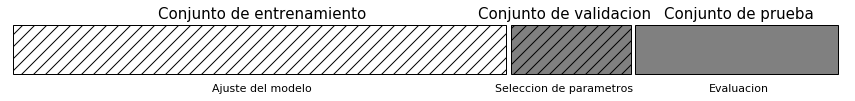

In [41]:
dibuja_division_tres_grupos()

Después de seleccionar los mejores parámetros usando el conjunto de validación, podemos reconstruir un modelo usando la configuración de parámetros que encontramos, pero ahora entrenando tanto en los datos de entrenamiento como en los datos de validación. De esta forma, podemos utilizar la mayor cantidad de datos posible para construir nuestro modelo. Esto lleva a la siguiente implementación:

In [47]:
from sklearn.svm import SVC
# dividimos los datos en conjuntos de entrenamiento+validacion y prueba
X_entrenamiento_validacion, X_prueba, y_entrenamiento_validacion, y_prueba = train_test_split(iris.data, iris.target, random_state=0)
    
# dividimos el conjunto entrenamiento+validacion en conjuntos de prueba y validacion
X_entrenamiento, X_validacion, y_entrenamiento, y_validacion = train_test_split(X_entrenamiento_validacion, y_entrenamiento_validacion, random_state=1)

print("Tamaño del conjunto de entrenamiento: {} Tamaño del conjunto de validacion: {} Tamaño del conjunto de prueba: {}"
      .format( X_entrenamiento.shape[0], X_validacion.shape[0], X_prueba.shape[0]))

mejor_puntuacion = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
    # para cada combinación de parámetros, entrenamos un SVC
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_entrenamiento, y_entrenamiento)
    
    # evaluamos SVC en el conjunto de prueba
        puntuacion = svm.score(X_validacion, y_validacion)
    # si tenemos una mejor puntuación, almacena la puntuación y los parámetros
        if puntuacion > mejor_puntuacion:
            mejor_puntuacion = puntuacion
            mejor_parametros = {'C': C, 'gamma': gamma}
# reconstruir un modelo en el conjunto  de entrenamiento y validación 
# y se  evalua en el conjunto de prueba

svm = SVC(**mejor_parametros)
svm.fit(X_entrenamiento_validacion, y_entrenamiento_validacion)
puntuacion_prueba = svm.score(X_prueba, y_prueba)
print("Mejor puntuacion en el conjunto de validacion: {:.2f}".format(mejor_puntuacion))
print("Mejores parametros: {:.2f}", mejor_parametros)
print("Puntuacion del conjunto de prueba con mejores parametros: {}".format(puntuacion_prueba))

Tamaño del conjunto de entrenamiento: 84 Tamaño del conjunto de validacion: 28 Tamaño del conjunto de prueba: 38
Mejor puntuacion en el conjunto de validacion: 0.96
Mejores parametros: {:.2f} {'C': 10, 'gamma': 0.001}
Puntuacion del conjunto de prueba con mejores parametros: 0.9210526315789473


El mejor puntaje en el conjunto de validación es 96%: levemente más bajo que antes, probablemente porque usamos menos datos para entrenar el modelo (X_train es más pequeño ahora porque dividimos nuestro conjunto de datos dos veces). Sin embargo, el puntaje en el conjunto de prueba, que realmente nos dice qué tan bien generalizamos, es aún más bajo, en un 92%. Por lo tanto, solo podemos afirmar que clasificamos los datos nuevos en un 92% de forma correcta, no en un 97% de manera correcta, como pensábamos antes. 

La distinción entre el conjunto de entrenamiento, el conjunto de validación y el conjunto de prueba es importante para la aplicación de métodos de machine learning  en la práctica. Cualquier elección hecha con base  en la precision del conjunto de prueba "pierde" información del conjunto de pruebas en el modelo. Por lo tanto, es importante mantener un conjunto de pruebas por separado, que solo se usa para la evaluación final.
